### Importing Data

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .getOrCreate()

In [2]:
text_rdd = spark.sparkContext.textFile('adult100k')
text_rdd_cleaned = text_rdd.map(lambda x: tuple(x.split(',')))

In [3]:
schema = StructType([
    StructField("Age", StringType(), True),  
    StructField("WorkClass", StringType(), True),
    StructField("Fnlwgt", StringType(), True),
    StructField("Education", StringType(), True),
    StructField("EducationNum", StringType(), True),
    StructField("MaritalStatus", StringType(), True),
    StructField("Occupation", StringType(), True),
    StructField("Relationship", StringType(), True),
    StructField("Race", StringType(), True),
    StructField("Sex", StringType(), True),
    StructField("CapitalGain", StringType(), True),
    StructField("CapitalLoss", StringType(), True),
    StructField("HoursPerWeek", StringType(), True),
    StructField("NativeCountry", StringType(), True),
    StructField("Income", StringType(), True)
])

spark_dataframe = spark.createDataFrame(text_rdd_cleaned, schema)

In [4]:
spark_dataframe.show(5)

+---+----------------+------+---------+------------+------------------+-----------------+-------------+-----+------+-----------+-----------+------------+-------------+------+
|Age|       WorkClass|Fnlwgt|Education|EducationNum|     MaritalStatus|       Occupation| Relationship| Race|   Sex|CapitalGain|CapitalLoss|HoursPerWeek|NativeCountry|Income|
+---+----------------+------+---------+------------+------------------+-----------------+-------------+-----+------+-----------+-----------+------------+-------------+------+
| 39|       State-gov| 77516|Bachelors|          13|     Never-married|     Adm-clerical|Not-in-family|White|  Male|       2174|          0|          40|United-States| <=50K|
| 50|Self-emp-not-inc| 83311|Bachelors|          13|Married-civ-spouse|  Exec-managerial|      Husband|White|  Male|          0|          0|          13|United-States| <=50K|
| 38|         Private|215646|  HS-grad|           9|          Divorced|Handlers-cleaners|Not-in-family|White|  Male|         

### Data Exploration 

In [5]:
# How many records in this dataframe? 
spark_dataframe.count()

100000

In [6]:
# Data Type Handling 
NumericalDataType = ['Age', 'Fnlwgt', 'EducationNum', 'CapitalGain', 'CapitalLoss', 'HoursPerWeek']

for col_name in NumericalDataType:
    spark_dataframe = spark_dataframe.withColumn(col_name, col(col_name).cast('float'))

In [7]:
# Missing Data / Imputations 
null_counts = spark_dataframe.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in spark_dataframe.columns))
null_counts.show()

+---+---------+------+---------+------------+-------------+----------+------------+----+---+-----------+-----------+------------+-------------+------+
|Age|WorkClass|Fnlwgt|Education|EducationNum|MaritalStatus|Occupation|Relationship|Race|Sex|CapitalGain|CapitalLoss|HoursPerWeek|NativeCountry|Income|
+---+---------+------+---------+------------+-------------+----------+------------+----+---+-----------+-----------+------------+-------------+------+
|  0|        0|     0|        0|           0|            0|         0|           0|   0|  0|          0|          0|           0|            0|     0|
+---+---------+------+---------+------------+-------------+----------+------------+----+---+-----------+-----------+------------+-------------+------+



#### Column Descriptions 
- Age : Age of person in years (Integer)
- WorkClass : Type of work that the person does (Catergorical)
- Fnlwgt : ? (Integer)
- Education : Highest Level of Education (Catergorical)
- EducationNum : Number of years completed of education (Integer) 
- MaritalStatus : Marital status of the person (Catergorical)
- Occupation : Person's profession (Catergorical) 
- Relationship : Familial status of the person (Catergorical)
- Race : Race of person (Catergorical)
- Sex : Sex of person (Catergorical)
- CapitalGain : ? (Integer)
- CapitalLoss : ? (Integer)
- HoursPerWeek : Hours per week that the person words (Integer) 
- NativeCountry : Country where the person lives (Catergorical) 
- Income : Whether or not the person makes over or under $50k (Catergorical) 

### Data Visualization

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
sampled_df = spark_dataframe.sample(withReplacement = False, fraction = 0.001, seed = 505)
sampled_df.count()

94

#### Numerical Variables

Age


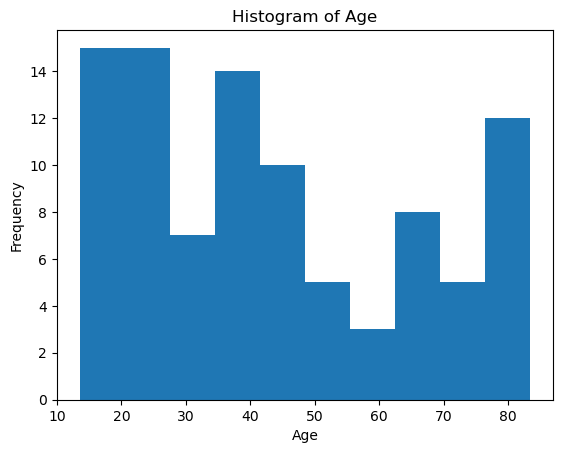

Fnlwgt


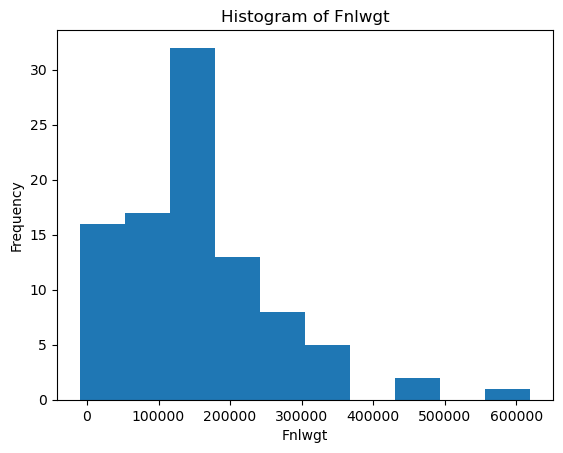

EducationNum


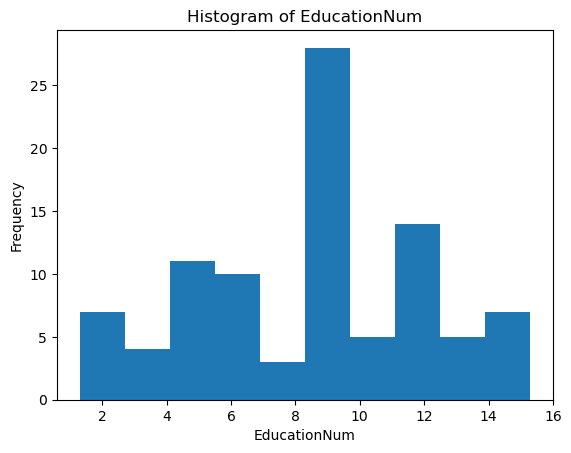

CapitalGain


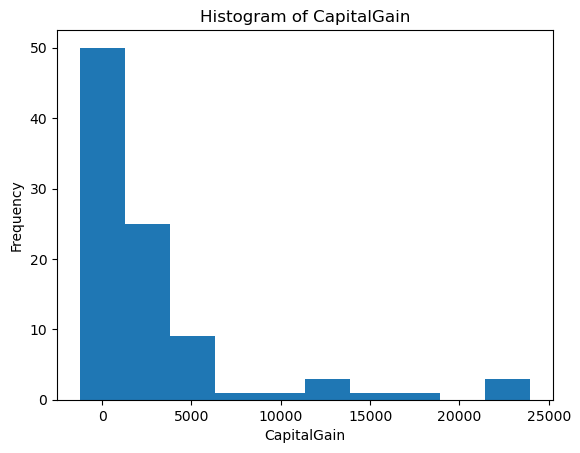

CapitalLoss


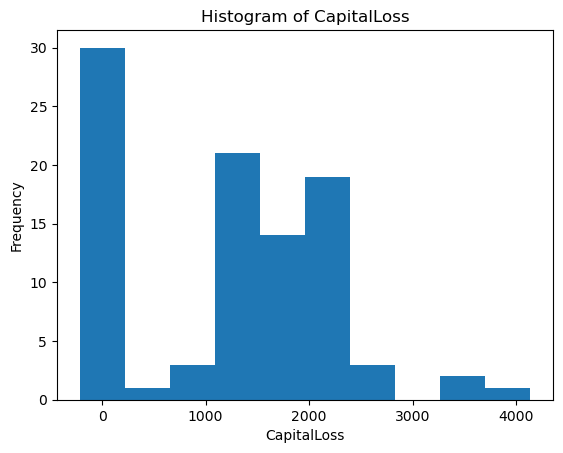

HoursPerWeek


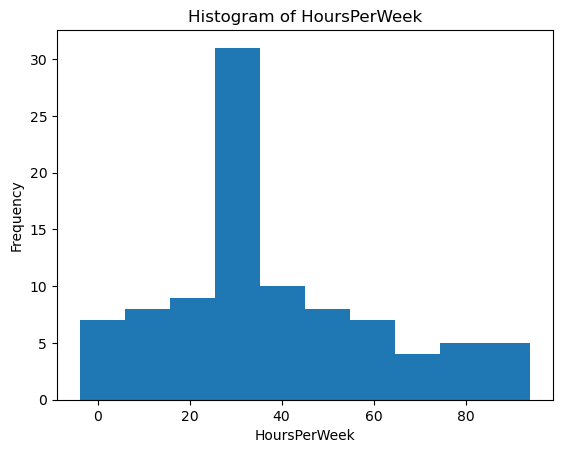

In [10]:
NumericalDataType = ['Age', 'Fnlwgt', 'EducationNum', 'CapitalGain', 'CapitalLoss', 'HoursPerWeek']

for i in NumericalDataType:

    print(i)
    hist_data = sampled_df.select(i).rdd.flatMap(lambda x: x).histogram(10)
    bins = hist_data[0]
    frequencies = hist_data[1]
    plt.bar(bins[:-1], frequencies, width=bins[1]-bins[0])
    plt.xlabel(i)
    plt.ylabel('Frequency')
    plt.title('Histogram of {}'.format(i))
    plt.show()

In [11]:
heatmap_data = sampled_df.select(NumericalDataType).toPandas()

<Axes: >

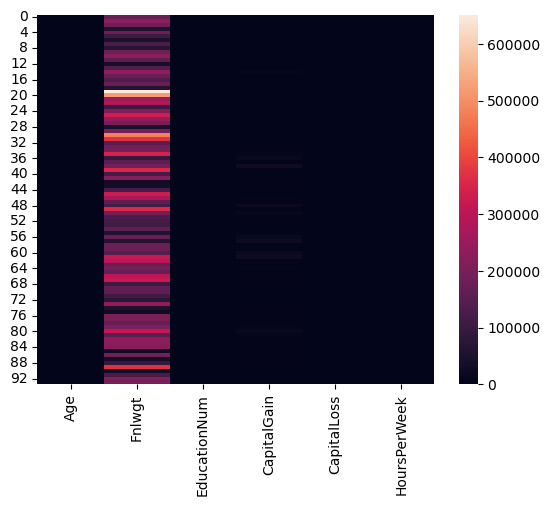

In [12]:
sns.heatmap(heatmap_data)

#### Catergorical Variables

In [13]:
list_of_columns = list(spark_dataframe.columns)

CatergoricalDataType = [el for el in list_of_columns if el not in NumericalDataType]

WorkClass


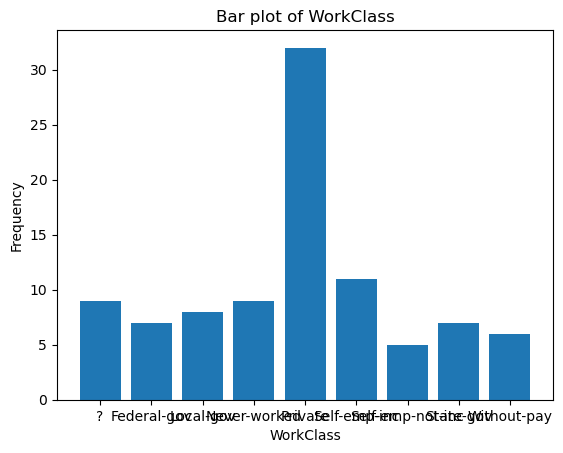

Education


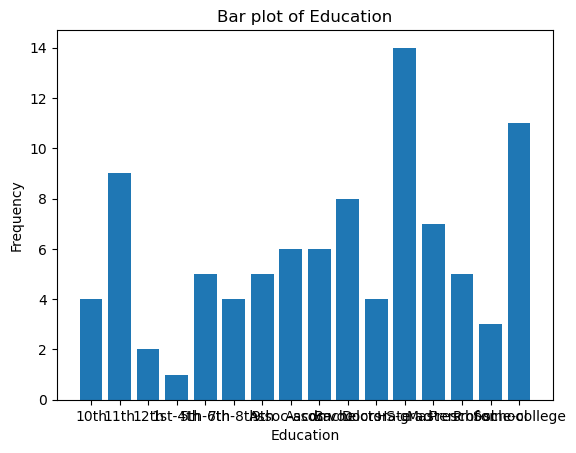

MaritalStatus


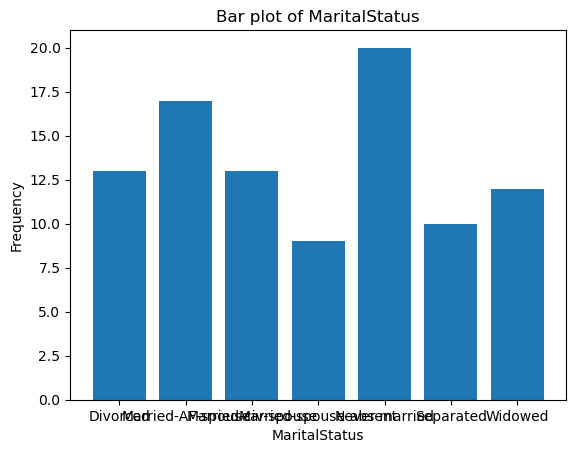

Occupation


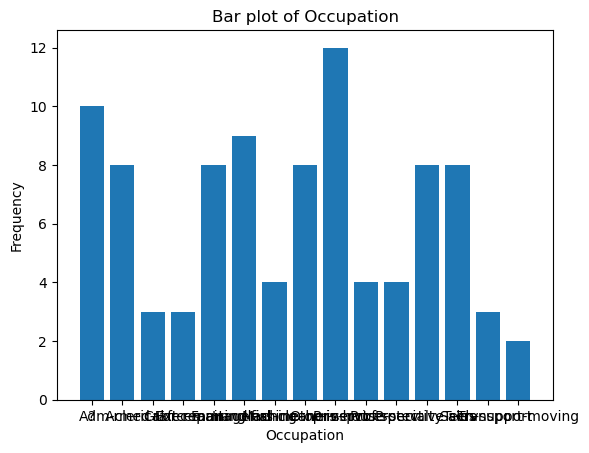

Relationship


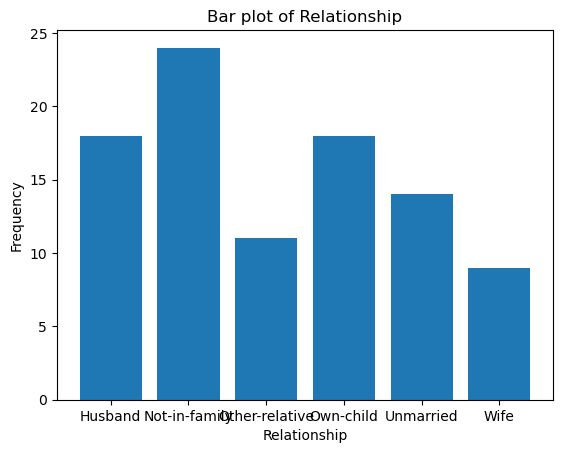

Race


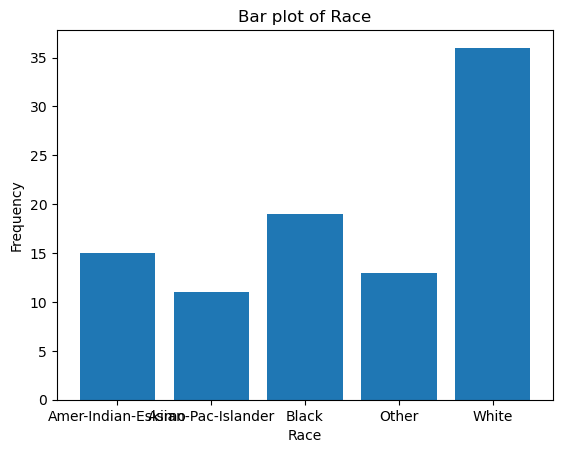

Sex


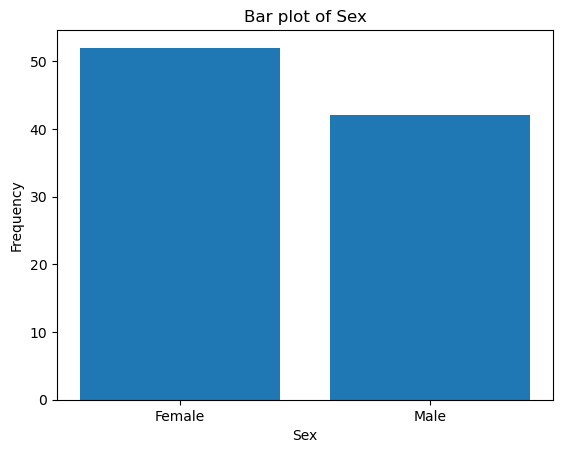

NativeCountry


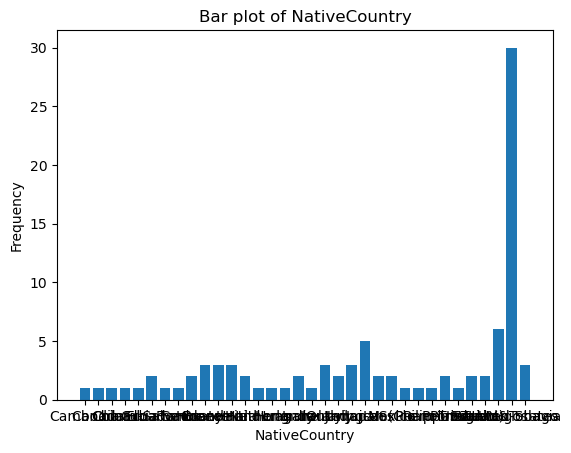

Income


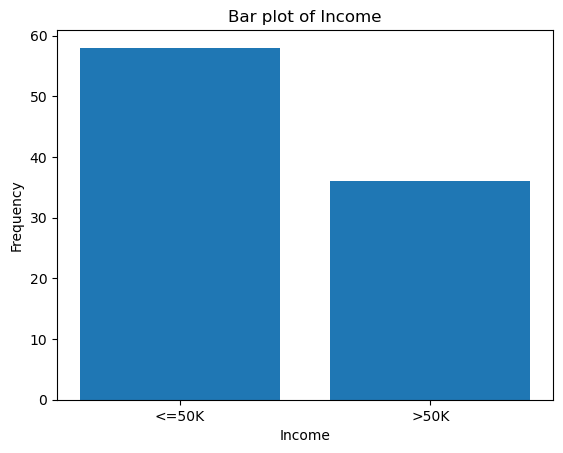

In [14]:
for i in CatergoricalDataType:
    
    print(i)
    value_counts = sampled_df.groupBy(i).count().orderBy(i).collect()
    
    values = [row[i] for row in value_counts]
    frequencies = [row['count'] for row in value_counts]
    
    plt.bar(values, frequencies)
    plt.xlabel(i)
    plt.ylabel('Frequency')
    plt.title('Bar plot of {}'.format(i))
    plt.show()

#### Response Variables

Education


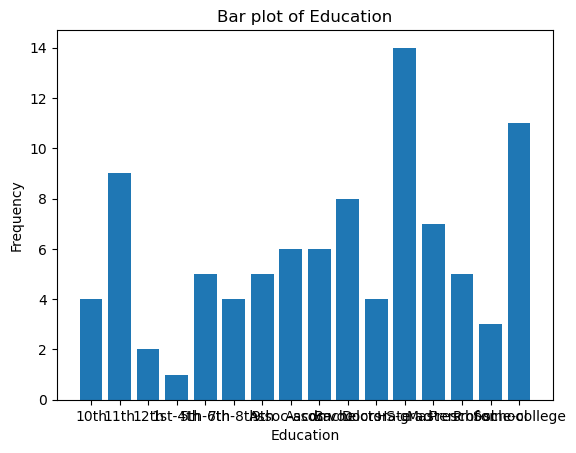

In [15]:
for i in ['Education']:

    print(i)
    value_counts = sampled_df.groupBy(i).count().orderBy(i).collect()

    values = [row[i] for row in value_counts]
    frequencies = [row['count'] for row in value_counts]

    plt.bar(values, frequencies)
    plt.xlabel(i)
    plt.ylabel('Frequency')
    plt.title('Bar plot of {}'.format(i))
    plt.show()

### Data Preprocessing

- Numerical variables have been composed into a vector in `NumericalDataType` column
- Dataset has been split to train, test and validation set in proportions: 60/20/20
- Numerical variables vector have been scaled using `StandardScaler` to better represent normal distribution
- Categorical variables have been converted into their numerical representation
- Dataframes have been filtered to contain only transformed columns

In [16]:
vector_assembler = VectorAssembler().setInputCols(NumericalDataType).setOutputCol('NumericalDataType')
spark_dataframe_transformed = vector_assembler.transform(spark_dataframe)

train_split, test_split, validation_split = spark_dataframe_transformed.randomSplit([0.6, 0.2, 0.2], seed=13)

scaler_model = StandardScaler().setInputCol('NumericalDataType').setOutputCol('NumericalDataTypeTransformed').fit(train_split)
scaled_train = scaler_model.transform(train_split)
scaled_test = scaler_model.transform(test_split)
scaled_validation = scaler_model.transform(validation_split)

scaled_train.show()

+----+---------+--------+------------+------------+--------------------+-----------------+--------------+------------------+------+-----------+-----------+------------+-------------+------+--------------------+----------------------------+
| Age|WorkClass|  Fnlwgt|   Education|EducationNum|       MaritalStatus|       Occupation|  Relationship|              Race|   Sex|CapitalGain|CapitalLoss|HoursPerWeek|NativeCountry|Income|   NumericalDataType|NumericalDataTypeTransformed|
+----+---------+--------+------------+------------+--------------------+-----------------+--------------+------------------+------+-----------+-----------+------------+-------------+------+--------------------+----------------------------+
|17.0|        ?| 34019.0|        10th|         6.0|       Never-married|                ?|     Own-child|             White|  Male|        0.0|        0.0|        20.0|United-States| <=50K|[17.0,34019.0,6.0...|        [0.84377759445743...|
|17.0|        ?| 41643.0|        11th|  

In [17]:
string_indexer = StringIndexer(inputCols=CatergoricalDataType, outputCols=[el + "Indexed" for el in CatergoricalDataType])
indexer_model = string_indexer.fit(train_split)
indexed_train = indexer_model.transform(scaled_train)
indexed_test = indexer_model.transform(scaled_test)
indexed_validation = indexer_model.transform(scaled_validation)

indexed_train.show()

+----+---------+--------+------------+------------+--------------------+-----------------+--------------+------------------+------+-----------+-----------+------------+-------------+------+--------------------+----------------------------+----------------+----------------+--------------------+-----------------+-------------------+-----------+----------+--------------------+-------------+
| Age|WorkClass|  Fnlwgt|   Education|EducationNum|       MaritalStatus|       Occupation|  Relationship|              Race|   Sex|CapitalGain|CapitalLoss|HoursPerWeek|NativeCountry|Income|   NumericalDataType|NumericalDataTypeTransformed|WorkClassIndexed|EducationIndexed|MaritalStatusIndexed|OccupationIndexed|RelationshipIndexed|RaceIndexed|SexIndexed|NativeCountryIndexed|IncomeIndexed|
+----+---------+--------+------------+------------+--------------------+-----------------+--------------+------------------+------+-----------+-----------+------------+-------------+------+--------------------+--------

In [18]:
preprocessed_columns = [el + "Indexed" for el in CatergoricalDataType] + ['NumericalDataTypeTransformed']
train = indexed_train.select(preprocessed_columns)
test = indexed_test.select(preprocessed_columns)
validation = indexed_validation.select(preprocessed_columns)

train.show()

+----------------+----------------+--------------------+-----------------+-------------------+-----------+----------+--------------------+-------------+----------------------------+
|WorkClassIndexed|EducationIndexed|MaritalStatusIndexed|OccupationIndexed|RelationshipIndexed|RaceIndexed|SexIndexed|NativeCountryIndexed|IncomeIndexed|NumericalDataTypeTransformed|
+----------------+----------------+--------------------+-----------------+-------------------+-----------+----------+--------------------+-------------+----------------------------+
|             3.0|             7.0|                 1.0|              7.0|                2.0|        0.0|       0.0|                 0.0|          0.0|        [0.84377759445743...|
|             3.0|             5.0|                 1.0|              7.0|                2.0|        0.0|       1.0|                 0.0|          0.0|        [0.84377759445743...|
|             3.0|             5.0|                 1.0|              7.0|                

### Data Download and Requirements

- Data can be downloaded off : https://www.kaggle.com/datasets/brijeshbmehta/adult-datasets